In [102]:
# set working directory
import sys
import os
sys.path.insert(0, r'd:\GSSA-Chem-Lith_Model')
os.chdir(sys.path[0])

#  GSSA Public Data Lithology Classification Model

In [103]:
# Import Packages
import plotly.io as pio
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

## Import XRF Chemistry Data

In [104]:
# Import chemistry data and examine the first 5 rows
clean_df = pd.read_csv('data/cleaned_pivoted_chem.csv')
clean_df.head()

,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHO_CONF,LITHOLOGY_NAME,LITHO_MODIFIER,MAP_SYMBOL,...,Ti_ppm,Tl_ppm,Tm_ppm,U_ppm,V_ppm,W_ppm,Y_ppm,Yb_ppm,Zn_ppm,Zr_ppm
0,2137547,PULP,"Pulp / powdered rock of known origin, typicall...",SSL,Sediment Siliciclastic Lutite,SLST,NaN,Siltstone,NaN,Nnt,...,6893.244620,1.49,0.53,3.57,153.0,2.000000,36.4,3.44,1188.0,190.0
1,2137548,PULP,"Pulp / powdered rock of known origin, typicall...",SCC,Sediment Chemical/Biogenic Carbonate,DLOM,NaN,Dolomite Rock,NaN,Nnt,...,1978.061500,1.27,0.20,21.16,54.0,0.000001,14.4,1.31,62.0,95.0
2,2137549,PULP,"Pulp / powdered rock of known origin, typicall...",IFE,Igneous Felsic Extrusive,RHYO,NaN,Rhyolite,NaN,Mau,...,7612.539711,0.87,0.71,5.38,114.0,2.000000,46.1,4.51,41.0,276.0
3,2137550,QCORE,Sawn quarter drill core,IFE,Igneous Felsic Extrusive,RHYO,NaN,Rhyolite,NaN,Mau,...,4615.476833,1.08,0.74,5.45,63.0,1.000000,47.8,4.81,41.0,300.0
4,2137551,PULP,"Pulp / powdered rock of known origin, typicall...",GB,Breccia (Undifferentiated),BREC,NaN,Breccia (Undiff. Origin),NaN,Mau,...,3596.475454,1.19,0.77,6.98,36.0,0.000001,49.5,5.15,40.0,312.0


In [105]:
# Remove records where the LITHOLOGY_NAME is absent
df = clean_df.dropna(subset=['LITHOLOGY_NAME'])
df = df.drop(['COLLECTORS_NUMBER', 'LITHO_CONF', 'LITHO_MODIFIER', 'STRAT_CONF'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 94 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SAMPLE_NO           478 non-null    int64  
 1   SAMPLE_SOURCE_CODE  478 non-null    object 
 2   SAMPLE_SOURCE       478 non-null    object 
 3   ROCK_GROUP_CODE     478 non-null    object 
 4   ROCK_GROUP          478 non-null    object 
 5   LITHO_CODE          478 non-null    object 
 6   LITHOLOGY_NAME      478 non-null    object 
 7   MAP_SYMBOL          478 non-null    object 
 8   STRAT_NAME          478 non-null    object 
 9   COLLECTED_BY        478 non-null    object 
 10  COLLECTED_DATE      478 non-null    object 
 11  DRILLHOLE_NUMBER    478 non-null    int64  
 12  DH_NAME             478 non-null    object 
 13  DH_DEPTH_FROM       478 non-null    float64
 14  DH_DEPTH_TO         478 non-null    float64
 15  SITE_NO             478 non-null    int64  
 16  EASTING_

In [106]:
# Create a dataframe of hole locations
map = df.drop_duplicates(subset=['DH_NAME'], keep='first')
map.to_csv('outputs/map.csv')

<Axes: xlabel='LITHOLOGY_NAME', ylabel='count'>

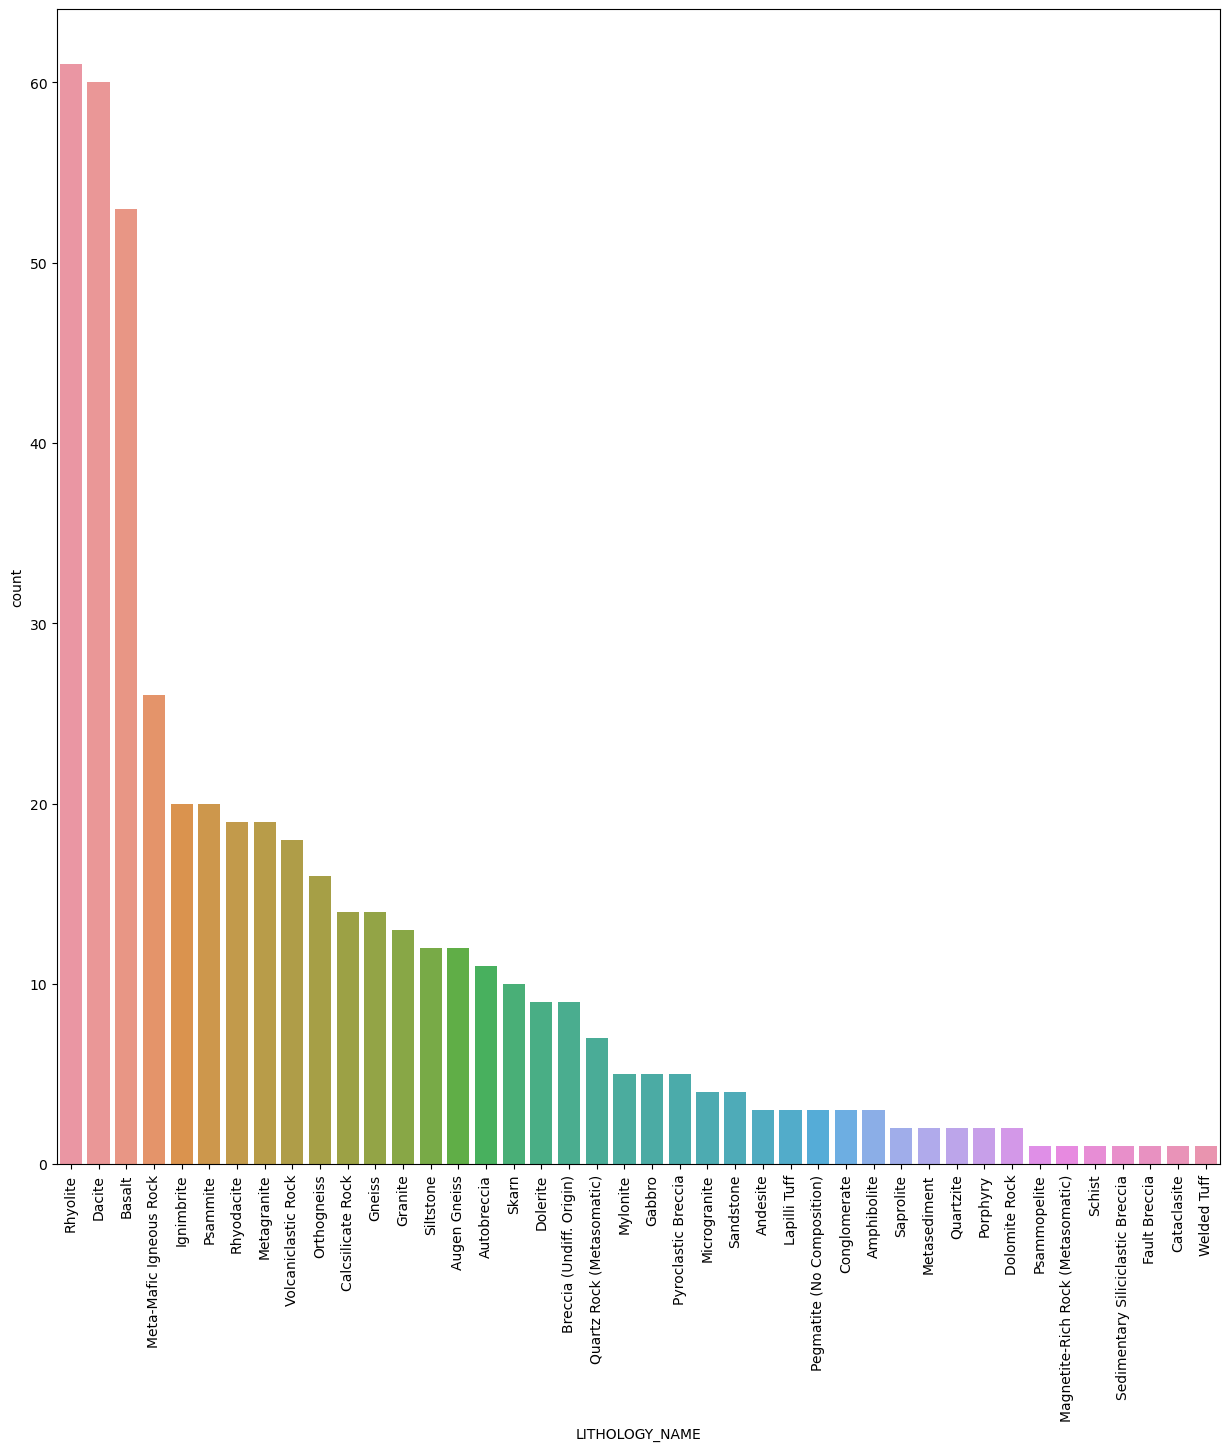

In [107]:
# Checkout the dominant class sets
Vis = df.groupby(["LITHOLOGY_NAME"]).size().sort_values(ascending=False).reset_index(name='count') 

plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.barplot(data=Vis, x="LITHOLOGY_NAME", y="count")

## Visualise an Example Striplog

In [108]:
# group by random drill hole and print out unique lithofacies
hole = df.loc[df['DH_NAME'] == 'MSDP01']
hole = hole.dropna(subset = ['LITHOLOGY_NAME'])
hole = hole.sort_values(by=['DH_DEPTH_FROM'])

print(hole['LITHOLOGY_NAME'].unique())

['Siltstone' 'Dolomite Rock' 'Rhyolite' 'Breccia (Undiff. Origin)'
 'Basalt' 'Sedimentary Siliciclastic Breccia' 'Volcaniclastic Rock'
 'Ignimbrite']


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


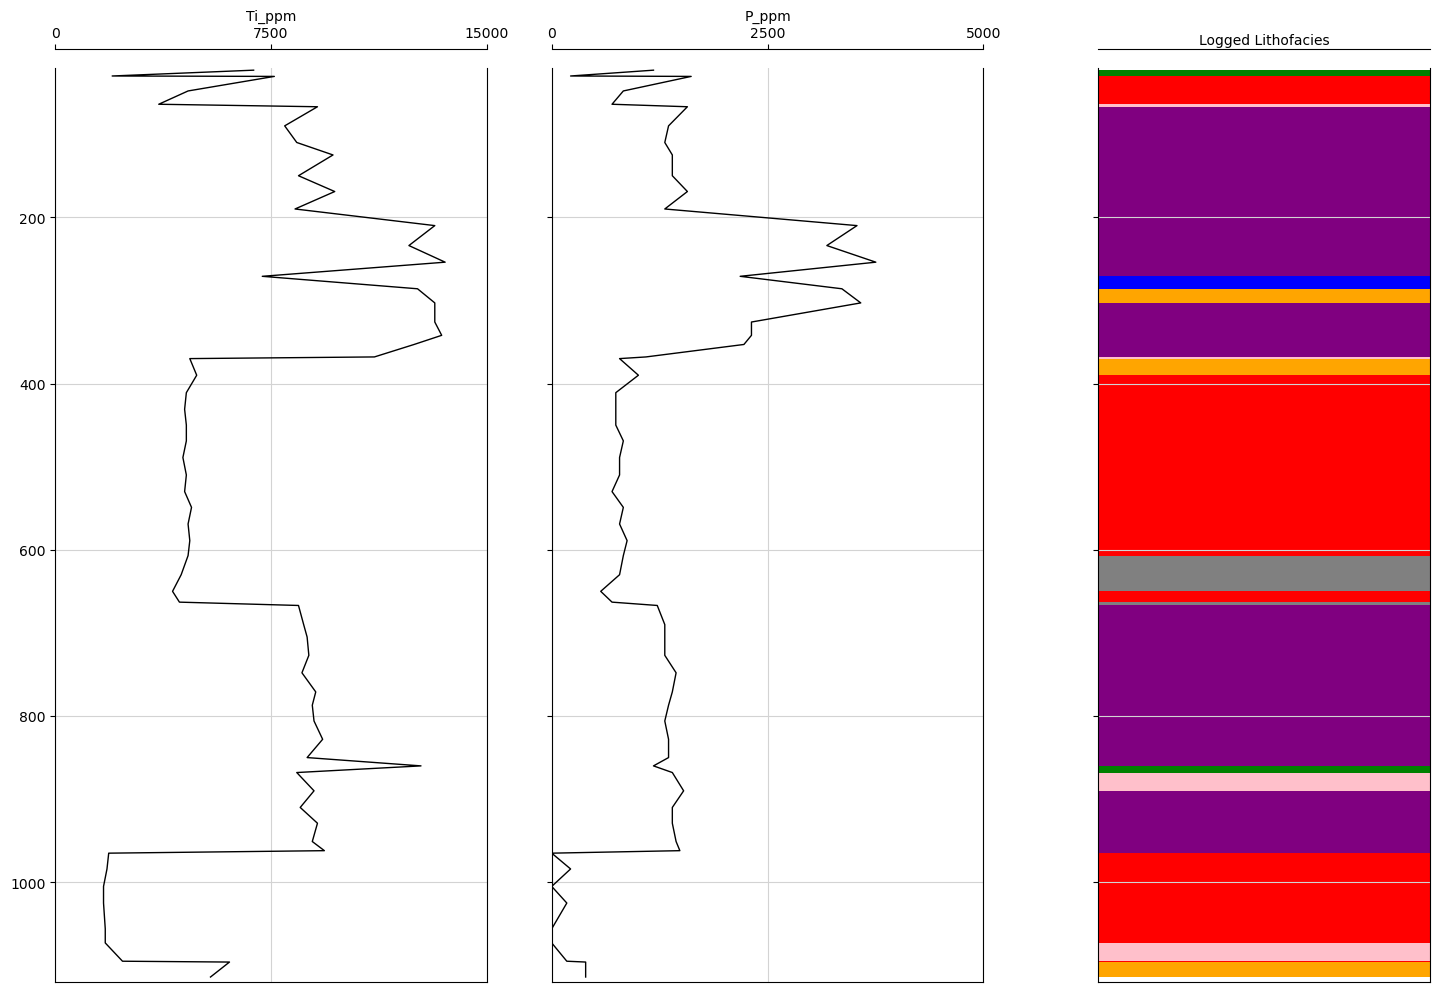

In [109]:
# Visualise Lithologies on a Strip Log

# Compare the results of clustering and cuttings interp
d1 = {'Siltstone': 1, 'Dolomite Rock': 2, 'Rhyolite': 3, 'Breccia (Undiff. Origin)': 4, 'Basalt': 5, 'Sedimentary Siliciclastic Breccia': 6, 'Volcaniclastic Rock': 7,
      'Ignimbrite': 8}
colors1 = ['green', 'blue','red', 'pink', 'purple', 'blue', 'orange', 'grey', 'yellow']
cmap1 = ListedColormap(colors1)

#Create function for strip log
def striplog(hole, bottom_depth, top_depth, var1, var2):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # MSDP01 Ti track
    ax1.plot(hole[var1], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax1.set_xlabel(var1)
    ax1.set_xlim(0, 15000)
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 7500, 15000])

    # MSDP01 P track
    ax2.plot(hole[var2], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax2.set_xlabel(var2)
    ax2.set_xlim(0, 5000)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 2500, 5000])

    # Lithofacies
    ax3.pcolormesh([-1, 3], hole['DH_DEPTH_FROM'], hole['LITHOLOGY_NAME'][:-1].map(d1).to_numpy().reshape(-1, 1),
              cmap=cmap1, vmin=1, vmax=len(colors1))
    ax3.set_xticks([])
    ax3.set_aspect(0.01)
    ax3.set_xlabel("Logged Lithofacies")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible = False)
       
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

striplog(hole, 1120, 20, "Ti_ppm", "P_ppm")

plt.savefig('outputs/MSDP01')
plt.show()

## Examine Class Distribution in Dataset

In [110]:
# binarize the Dependant Variable
bin = df.copy()
bin['LITHOLOGY_NAME'] = (bin['LITHOLOGY_NAME'] == 'Basalt').astype(int)

# Define X and y
X = bin.loc[:,'Ag_ppm':'Zr_ppm']
y = bin['LITHOLOGY_NAME']

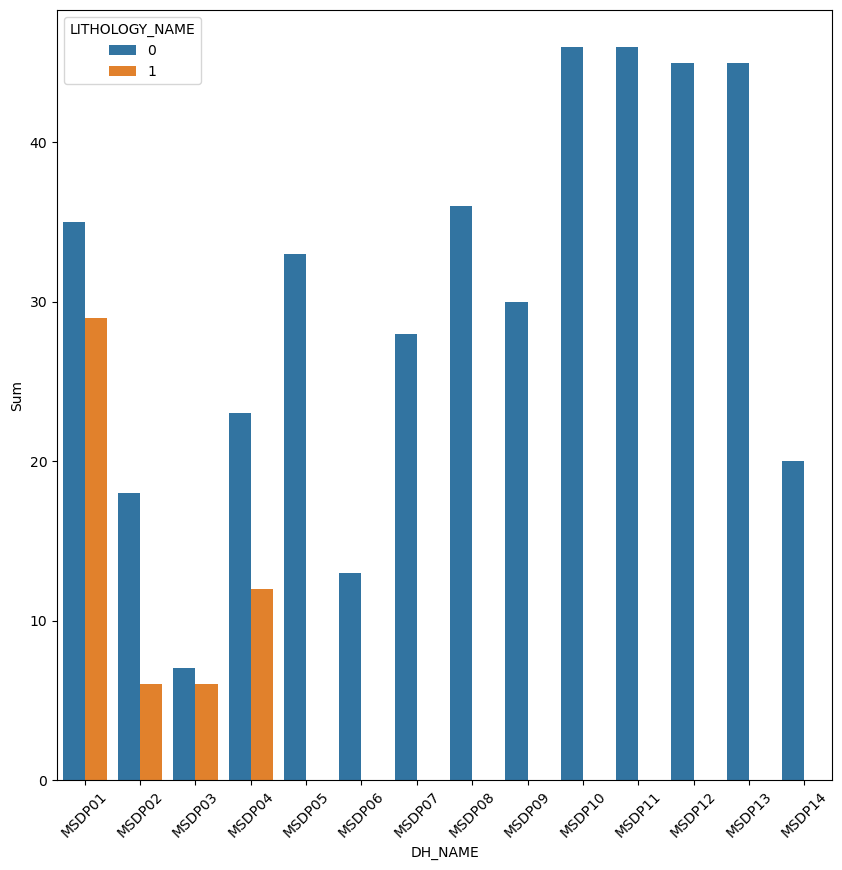

In [111]:
# visualise labels for each drill-hole
grpd = bin.groupby(['DH_NAME','LITHOLOGY_NAME']).size().reset_index().rename(columns={0: 'Sum'})

# grouped barplot
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.barplot(x="DH_NAME", y="Sum", hue="LITHOLOGY_NAME", data=grpd)
plt.savefig('outputs/Class_imbalance')

## Run an Example Train/Test Split

Test Set Accuracy: 0.965 %
Test Set Balanced Accuracy: 0.909 %
Test Set Matthews Correlation Coefficient: 0.838 %
Test Set ROC AUC: 0.909 %


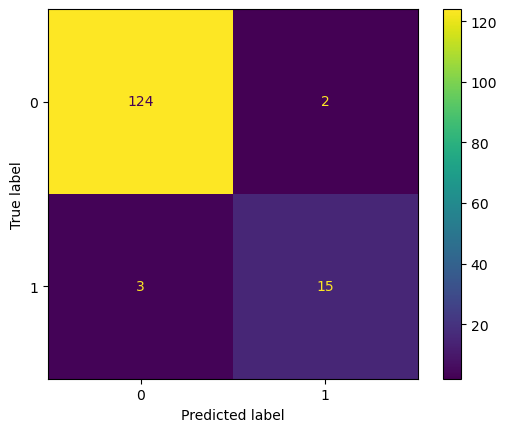

In [112]:
# run a random forest model with no sampling process
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Invoke Random Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


RF = RandomForestClassifier(random_state=42) # Create classifier
RF.fit(X_train, y_train) # train the model
y_pred_train = RF.predict(X_train) # generate predictions for training set
y_pred_RF = RF.predict(X_test) # generate predictions for test set

# Calculate the Performance Metrics
print("Test Set Accuracy: {:.3f} %".format(accuracy_score(y_test, y_pred_RF)))
print("Test Set Balanced Accuracy: {:.3f} %".format(balanced_accuracy_score(y_test, y_pred_RF)))
print("Test Set Matthews Correlation Coefficient: {:.3f} %".format(matthews_corrcoef(y_test, y_pred_RF)))
print("Test Set ROC AUC: {:.3f} %".format(roc_auc_score(y_test, y_pred_RF)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF.classes_)
disp.plot()

plt.show()

In [113]:
## Develop a Spatial Holdout Method

In [114]:
# Create function for holding out individual holes
def hold_out(hole_id):
    hole = bin.loc[df['DH_NAME'] == hole_id]
    train = bin.loc[df['DH_NAME'] != hole_id]

    return(hole, train)

# Create list of holes 
holes = df['DH_NAME'].unique()

<Axes: xlabel='LITHOLOGY_NAME'>

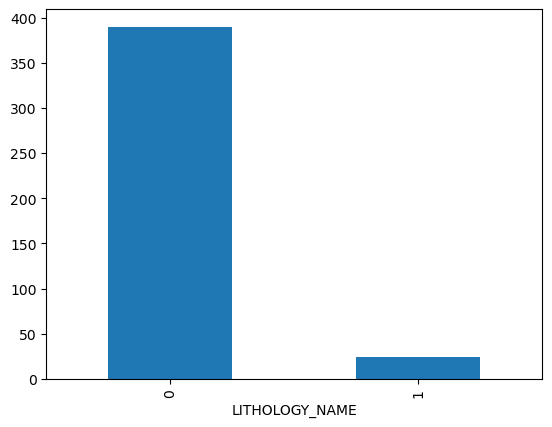

In [115]:
# Define train and test example for a single hole
test, train = hold_out('MSDP01')

# Create X and y variables
X_test = test.loc[:,'Ag_ppm':'Zr_ppm']
X_train = train.loc[:,'Ag_ppm':'Zr_ppm']

y_test = test['LITHOLOGY_NAME']
y_train = train['LITHOLOGY_NAME']

# Show imbalnced class sets for MSDP01
train.groupby(['LITHOLOGY_NAME']).size().plot.bar()

Test Set Balanced Accuracy: 0.865 %
Test Set Matthews Correlation Coefficient: 0.757 %
Test Set ROC AUC: 0.865 %


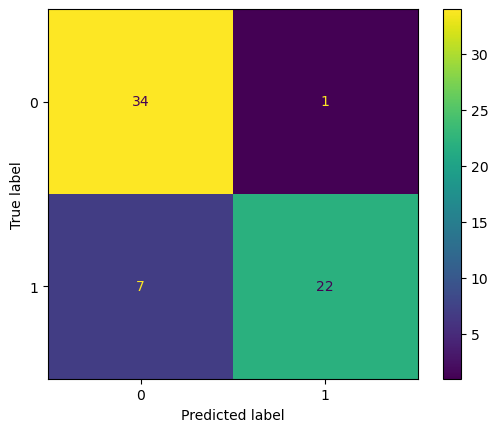

In [116]:
# run a random forest model with no sampling process
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


RF = RandomForestClassifier(random_state=42) # Create classifier
RF.fit(X_train, y_train) # train the model
y_pred_train = RF.predict(X_train) # generate predictions for training set
y_pred_RF = RF.predict(X_test) # generate predictions for test set

# Calculate the Performance Metrics
print("Test Set Balanced Accuracy: {:.3f} %".format(balanced_accuracy_score(y_test, y_pred_RF)))
print("Test Set Matthews Correlation Coefficient: {:.3f} %".format(matthews_corrcoef(y_test, y_pred_RF)))
print("Test Set ROC AUC: {:.3f} %".format(roc_auc_score(y_test, y_pred_RF)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF.classes_)
disp.plot()

plt.show()


In [117]:
# Add predictions back to the test set
test['RF _Predictions'] = y_pred_RF
hole = test.copy()

hole = hole.sort_values(by=['DH_DEPTH_FROM'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


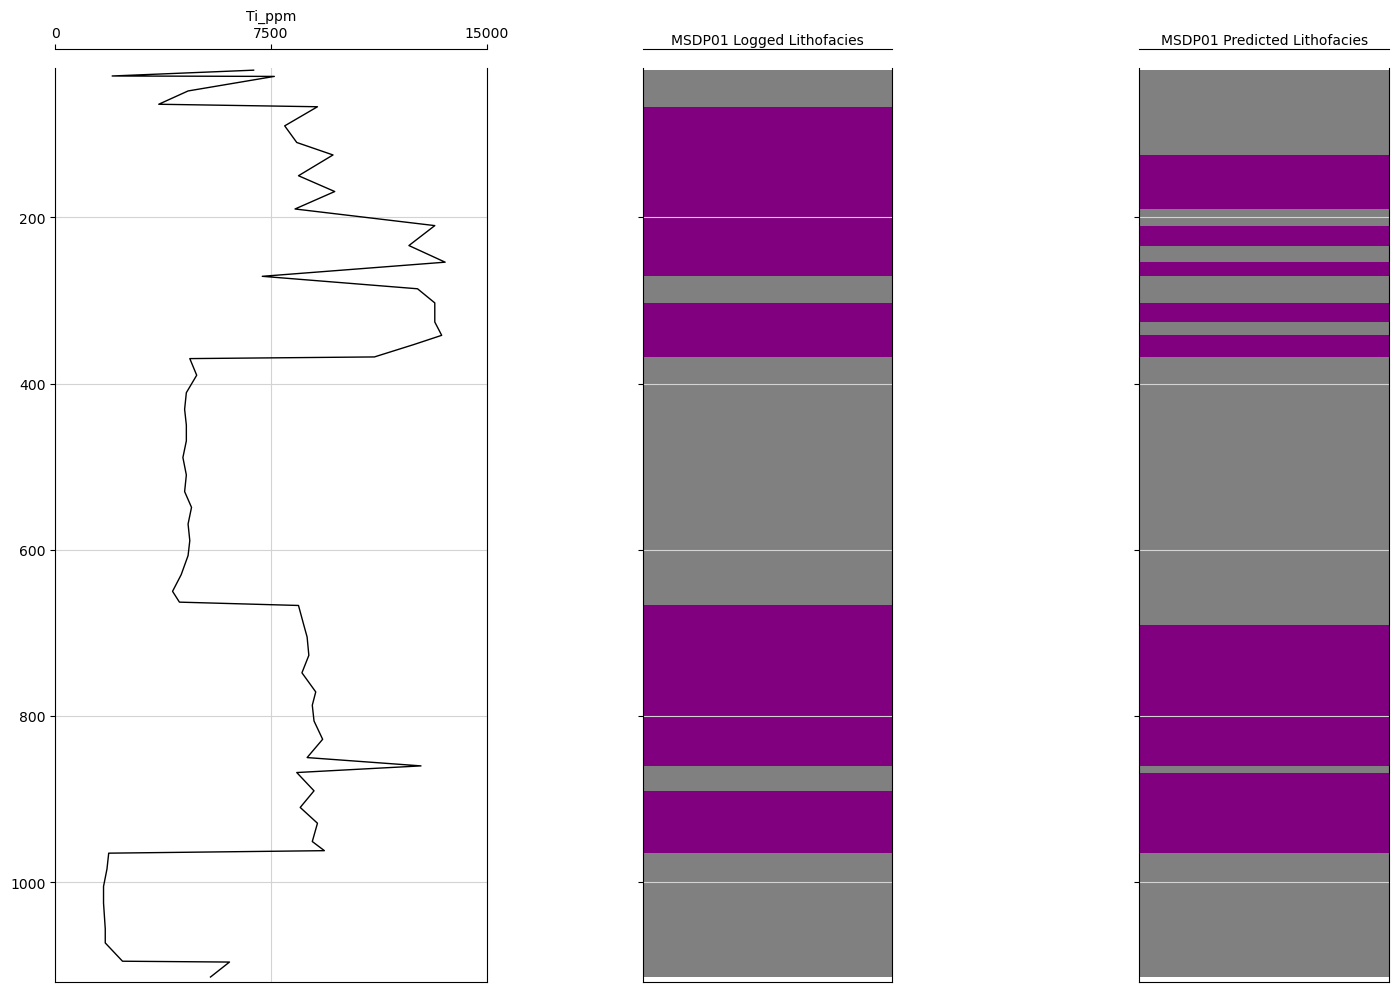

In [118]:
# Visualise striplot of predicitions
# Compare the results of clustering and cuttings interp
d1 = {0: 1, 1: 2}
colors1 = ['grey', 'purple']
cmap1 = ListedColormap(colors1)

d2 = {0: 1, 1: 2}
colors2 = ['grey', 'purple']
cmap2 = ListedColormap(colors2)

def striplog(hole, bottom_depth, top_depth):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # MSDP01 Ti track
    ax1.plot(hole["Ti_ppm"], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax1.set_xlabel("Ti_ppm")
    ax1.set_xlim(0, 15000)
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 7500, 15000])

    # Lithofacies
    ax2.pcolormesh([-1, 2], hole['DH_DEPTH_FROM'], hole['LITHOLOGY_NAME'][:-1].map(d1).to_numpy().reshape(-1, 1),
              cmap=cmap1, vmin=1, vmax=len(colors1))
    ax2.set_xticks([])
    ax2.set_aspect(0.01)
    ax2.set_xlabel("MSDP01 Logged Lithofacies")

    # Predictions
    ax3.pcolormesh([-1, 2], hole['DH_DEPTH_FROM'], hole['RF _Predictions'][:-1].map(d2).to_numpy().reshape(-1, 1),
              cmap=cmap2, vmin=1, vmax=len(colors2))
    ax3.set_xticks([])
    ax3.set_aspect(0.01)
    ax3.set_xlabel("MSDP01 Predicted Lithofacies")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible = False)
       
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

striplog(hole, 1120, 20)

plt.savefig('outputs/MSDP01_Predictions')
plt.show()


## Attempt Workflow using Synthetic Oversampling

In [119]:
# Invoke ADYSN oversampling to balance classes (ref)
from imblearn.over_sampling import ADASYN
from collections import Counter

ada = ADASYN(random_state=42)

X_res, y_res = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 390, 1: 390})


Test Set Balanced Accuracy: 0.954 %
Test Set Matthews Correlation Coefficient: 0.906 %
Test Set ROC AUC: 0.954 %


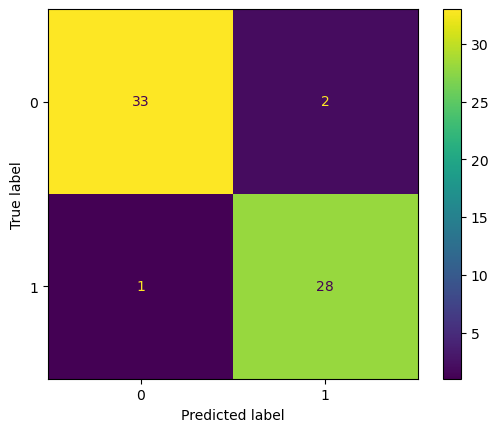

In [120]:
# Re run model with Synthetic Oversampling

RF = RandomForestClassifier(random_state=42) # Create classifier
RF.fit(X_res, y_res) # train the model
y_pred_train = RF.predict(X_res) # generate predictions for training set
y_pred_RF = RF.predict(X_test) # generate predictions for test set

# Calculate the Performance Metrics
print("Test Set Balanced Accuracy: {:.3f} %".format(balanced_accuracy_score(y_test, y_pred_RF)))
print("Test Set Matthews Correlation Coefficient: {:.3f} %".format(matthews_corrcoef(y_test, y_pred_RF)))
print("Test Set ROC AUC: {:.3f} %".format(roc_auc_score(y_test, y_pred_RF)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF.classes_)
disp.plot()

plt.show()

##Apply Recursive Feature Elimination

In [121]:
# Removing Correlated Features
corr_matrix = X_res.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Get features with correlations of greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
X_filt = X_res.copy()
X_filt.drop(to_drop, axis=1)
X_filt_test.drop(to_drop, axis=1)

X_filt_test = X_test.copy()
X_filt_test.drop(to_drop, axis=1)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,Ag_ppm,Al_ppm,As_ppm,Au_ppm,Ba_ppm,Be_ppm,Ca_ppm,Cd_ppm,Ce_ppm,Co_ppm,...,Re_ppm,S_ppm,Sb_ppm,Se_ppm,Sn_ppm,Sr_ppm,Te_ppm,Th_ppm,U_ppm,W_ppm
0,2.31,72611.802064,25.000000,0.000300,348.2,4.5,25148.367953,2.840000,92.7,27.7,...,0.000001,19079.000000,1.77,0.000001,4.0,83.0,0.100000,16.81,3.57,2.000000
1,2.74,26726.647261,26.000000,0.000300,1211.1,3.5,107344.213650,0.800000,53.4,19.7,...,0.004000,9092.000000,2.06,1.200000,1.0,68.5,0.090000,6.27,21.16,0.000001
2,0.21,70971.156391,5.700000,0.000001,1422.2,3.2,14985.163205,0.000001,125.2,13.1,...,0.000001,525.000000,0.53,0.000001,3.0,65.8,0.060000,28.56,5.38,2.000000
3,0.07,69648.055041,4.700000,0.000001,1065.4,3.0,6899.109792,0.000001,171.2,10.5,...,0.000001,75.000000,0.74,0.000001,3.0,34.1,0.050000,36.91,5.45,1.000000
4,0.98,67319.396666,16.500000,0.000001,1067.5,6.3,2448.071217,0.000001,265.8,8.8,...,0.002000,173.000000,0.91,0.000001,4.0,42.7,0.070000,50.79,6.98,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.11,64884.890183,0.000001,0.000001,1000.5,4.2,3189.910979,0.120000,201.9,2.1,...,0.000001,0.000001,0.61,0.000001,4.0,51.7,0.000001,47.04,9.01,0.000001
60,0.07,64937.814237,0.000001,0.000001,554.3,4.0,2967.359050,0.100000,181.5,1.6,...,0.000001,0.000001,0.67,0.000001,4.0,38.9,0.000001,46.64,11.75,1.000000
61,0.09,77745.435300,3.400000,0.000001,1182.1,4.5,3115.727003,0.140000,229.3,5.1,...,0.000001,0.000001,0.72,0.000001,8.0,113.8,0.000001,56.05,8.63,2.000000
62,0.10,91823.233660,4.500000,0.000001,454.2,5.0,2670.623145,0.140000,222.6,10.3,...,0.000001,258.000000,0.98,0.000001,4.0,50.3,0.050000,43.29,10.05,7.000000


In [122]:
# implement RFE with stratified sampling
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator= rfc, step=1, cv=StratifiedKFold(3), scoring='roc_auc')
rfecv.fit(X_filt, y_res)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=42), scoring='roc_auc')

Optimal number of features: 14


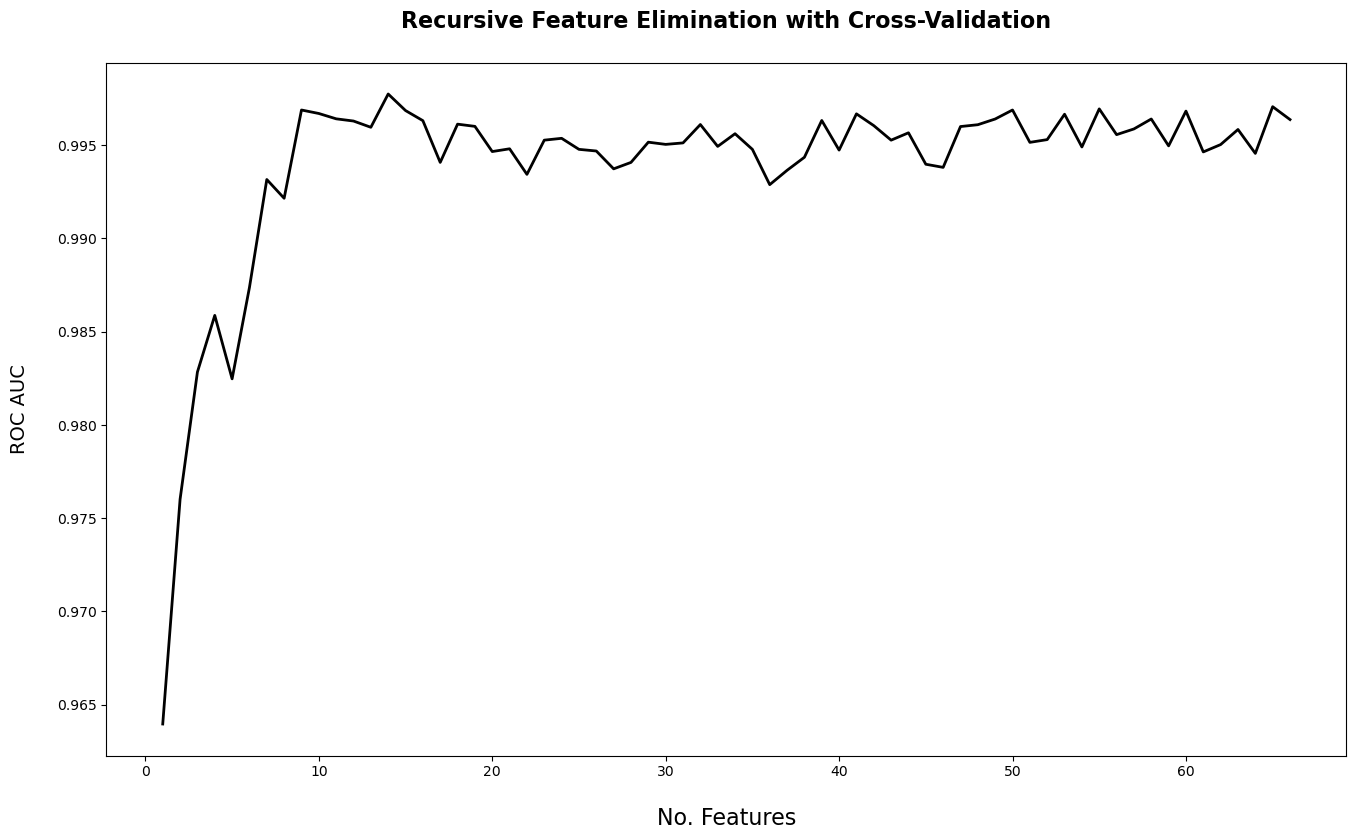

In [123]:
# Visualise the affect on performance of RFE
print('Optimal number of features: {}'.format(rfecv.n_features_))

# Plot the accuracy obtained per each number of feature used
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=16, fontweight='bold', pad=25)
plt.xlabel('No. Features', fontsize=16, labelpad=20)
plt.ylabel('ROC AUC', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='black', linewidth=2)

plt.savefig('outputs/RFE_Performance')
plt.show()

In [124]:
# Remove unwanted features
print(np.where(rfecv.support_ == False)[0])

# Filter variables
X_filt = X_res.drop(X_res.columns[np.where(rfecv.support_ == False)[0]], axis=1)
X_test_filt = X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1)

[ 0  1  2  3  4  8  9 11 12 13 16 17 19 20 21 22 23 24 25 26 27 28 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 49 50 51 52 53 54 55 58 59
 62 63 64 65]


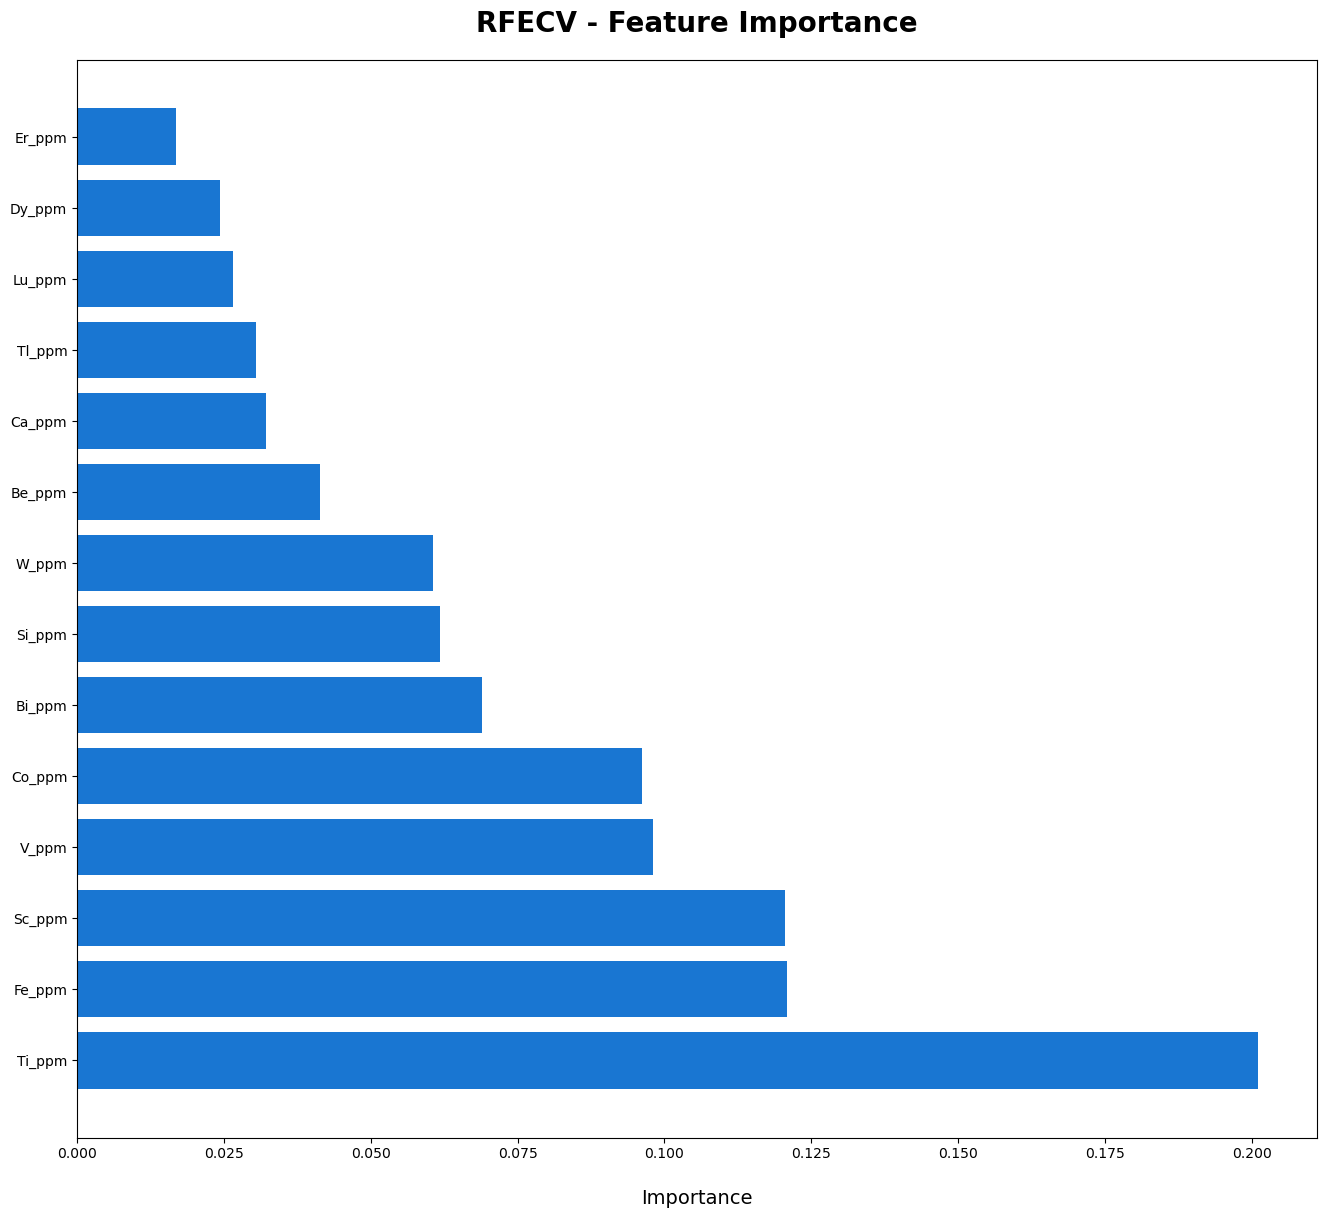

In [125]:
# Visualise the Feature Importances

dset = pd.DataFrame()
dset['attr'] = X_filt.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importance', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)

plt.savefig('outputs/RFE_Performance.png')
plt.show()

Test Set Balanced Accuracy: 0.934 %
Test Set Matthews Correlation Coefficient: 0.875 %
Test Set ROC AUC: 0.934 %


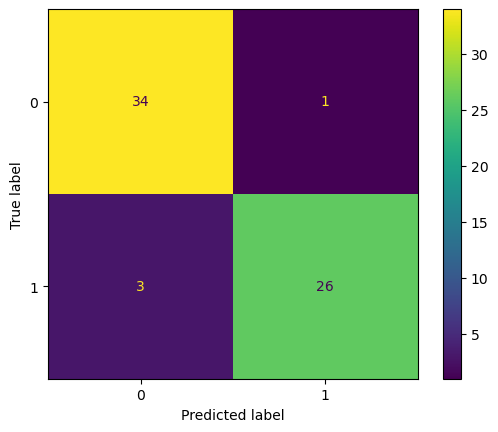

In [126]:
# Retrain and Test the model with RFE nd Cross Val

RF_rfe = RandomForestClassifier(random_state=42) # Create classifier
RF_rfe.fit(X_filt, y_res) # train the model
y_pred_train = RF_rfe.predict(X_filt) # generate predictions for training set
y_pred_RF = RF_rfe.predict(X_test_filt) # generate predictions for test set

# Calculate the Performance Metrics
print("Test Set Balanced Accuracy: {:.3f} %".format(balanced_accuracy_score(y_test, y_pred_RF)))
print("Test Set Matthews Correlation Coefficient: {:.3f} %".format(matthews_corrcoef(y_test, y_pred_RF)))
print("Test Set ROC AUC: {:.3f} %".format(roc_auc_score(y_test, y_pred_RF)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RF.classes_)
disp.plot()

plt.show()

## Model Explainability, Feature Importance

In [127]:
import shap
shap.initjs()

# Fits the explainer
explainer = shap.Explainer(RF.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 65it [00:36,  1.31it/s]                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


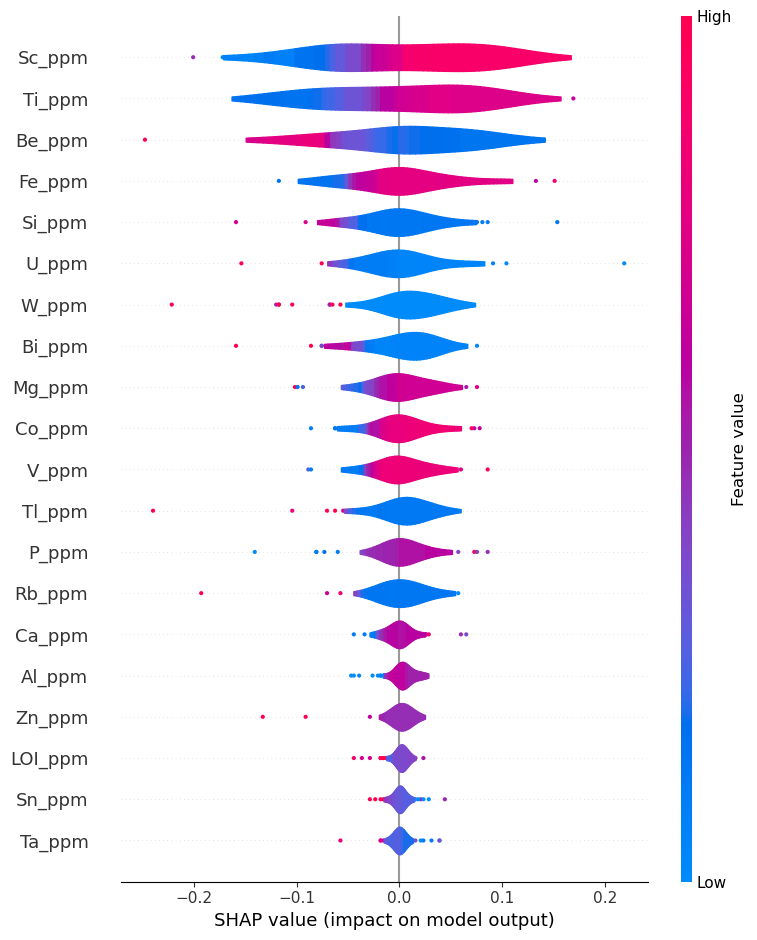

In [128]:
fig = shap.summary_plot(shap_values, plot_type='violin')

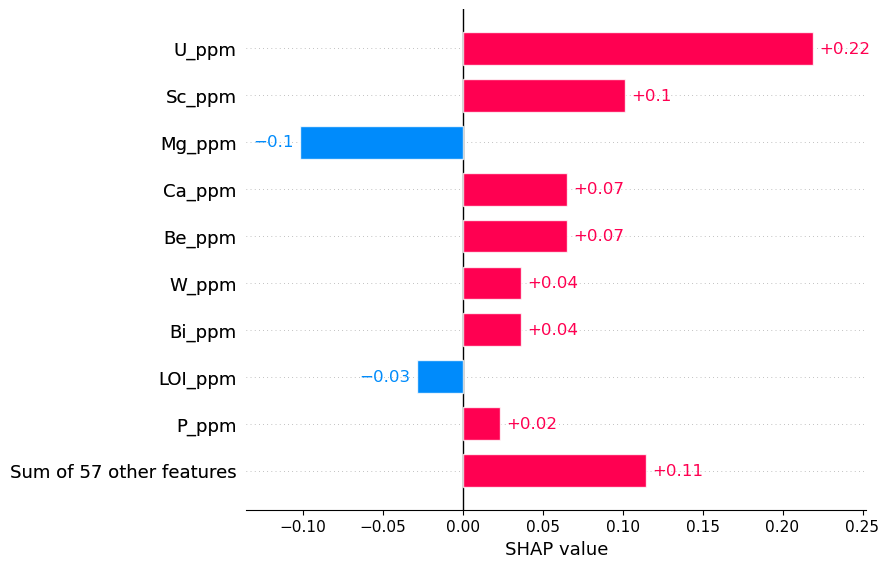

In [129]:
# Shap values for one record
shap.plots.bar(shap_values[30])

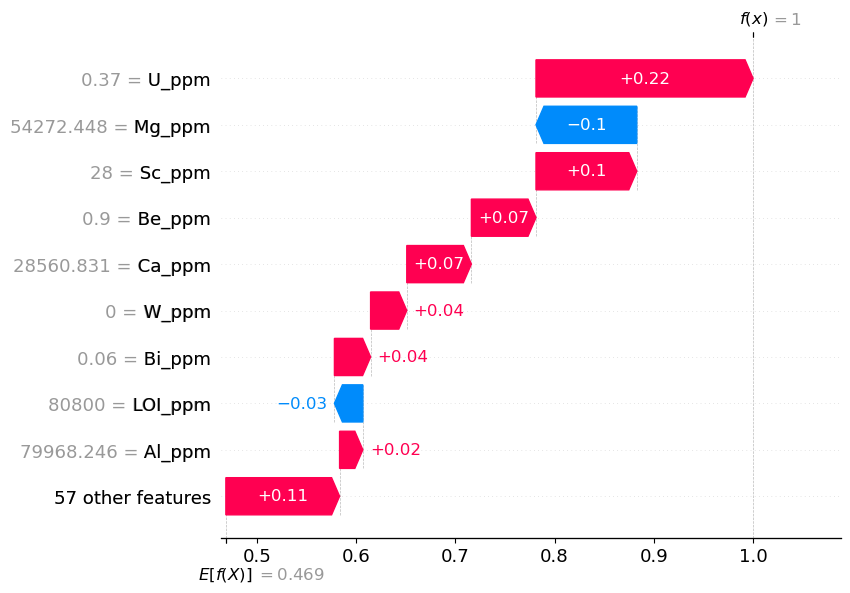

In [130]:
# Waterfall plot for one record
shap.plots.waterfall(shap_values[30])

In [131]:
# Force plot for one record
shap.plots.force(shap_values[30])

## Design a Spatial Validation Approach

In [132]:
print(holes)

['MSDP01' 'MSDP02' 'MSDP03' 'MSDP04' 'MSDP06' 'MSDP05' 'MSDP07' 'MSDP08'
 'MSDP09' 'MSDP10' 'MSDP11' 'MSDP12' 'MSDP13' 'MSDP14']


In [133]:
# Create a loop to generate predicts for every hole
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, roc_auc_score, f1_score, recall_score 
import statistics

# Create lists to append to
ROC = []
f1 = []
acc = []
rec = []
probs = []
hole = []

# Create a list of Validation holes (those that contain basalt)
Validation = ["MSDP01", "MSDP02", "MSDP03", "MSDP04"]

for h in holes:
    test, train = hold_out(h)

    # split out variables
    X_test = test.loc[:,'Ag_ppm':'Zr_ppm']
    X_train = train.loc[:,'Ag_ppm':'Zr_ppm']

    y_test = test['LITHOLOGY_NAME']
    y_train = train['LITHOLOGY_NAME']

    # Resample using ADYSN
    X_res, y_res = ada.fit_resample(X_train, y_train)
    
    # train model and run inference
    RF = RandomForestClassifier(random_state=42) # Create classifier
    RF.fit(X_res, y_res) # train the model
    y_pred_train = RF.predict(X_res) # generate predictions for training set
    y_pred_RF = RF.predict(X_test) # generate predictions for test set
    
    probs.append(RF.predict_proba(X_test)[:,1]) # generate probabilities for each prediction

    # get name of hole for each iteration 
    hole.append(h)


    # append performance metrics
    acc.append(balanced_accuracy_score(y_test, y_pred_RF))

# Print Average Performance Metrics
print("Test Set Accuracy: {:.3f} %"  .format(statistics.mean(acc)*100))
print("Accuracy Standard Deviation: {:.3f} %"  .format(statistics.stdev(acc)*100))

Test Set Accuracy: 93.101 %
Accuracy Standard Deviation: 14.747 %


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0., 11.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

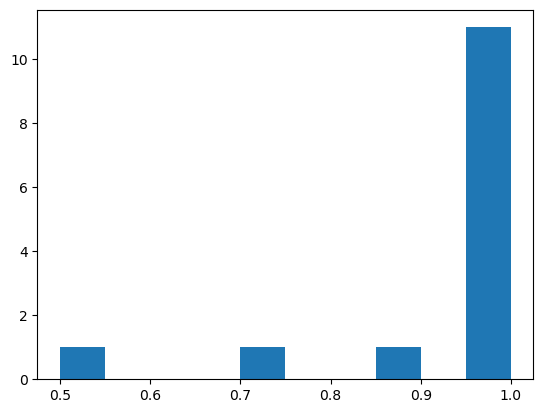

In [134]:
# Show histogram of validation scores
plt.hist(acc, bins=10)

In [135]:
# group by MSDP02
hole = df.loc[df['DH_NAME'] == 'MSDP02']
hole = hole.dropna(subset = ['LITHOLOGY_NAME'])
hole = hole.sort_values(by=['DH_DEPTH_FROM'])
hole['MSDP02_Preds'] = probs[1]


print(hole['LITHOLOGY_NAME'].unique())

['Siltstone' 'Sandstone' 'Conglomerate' 'Dolomite Rock' 'Autobreccia'
 'Basalt']


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


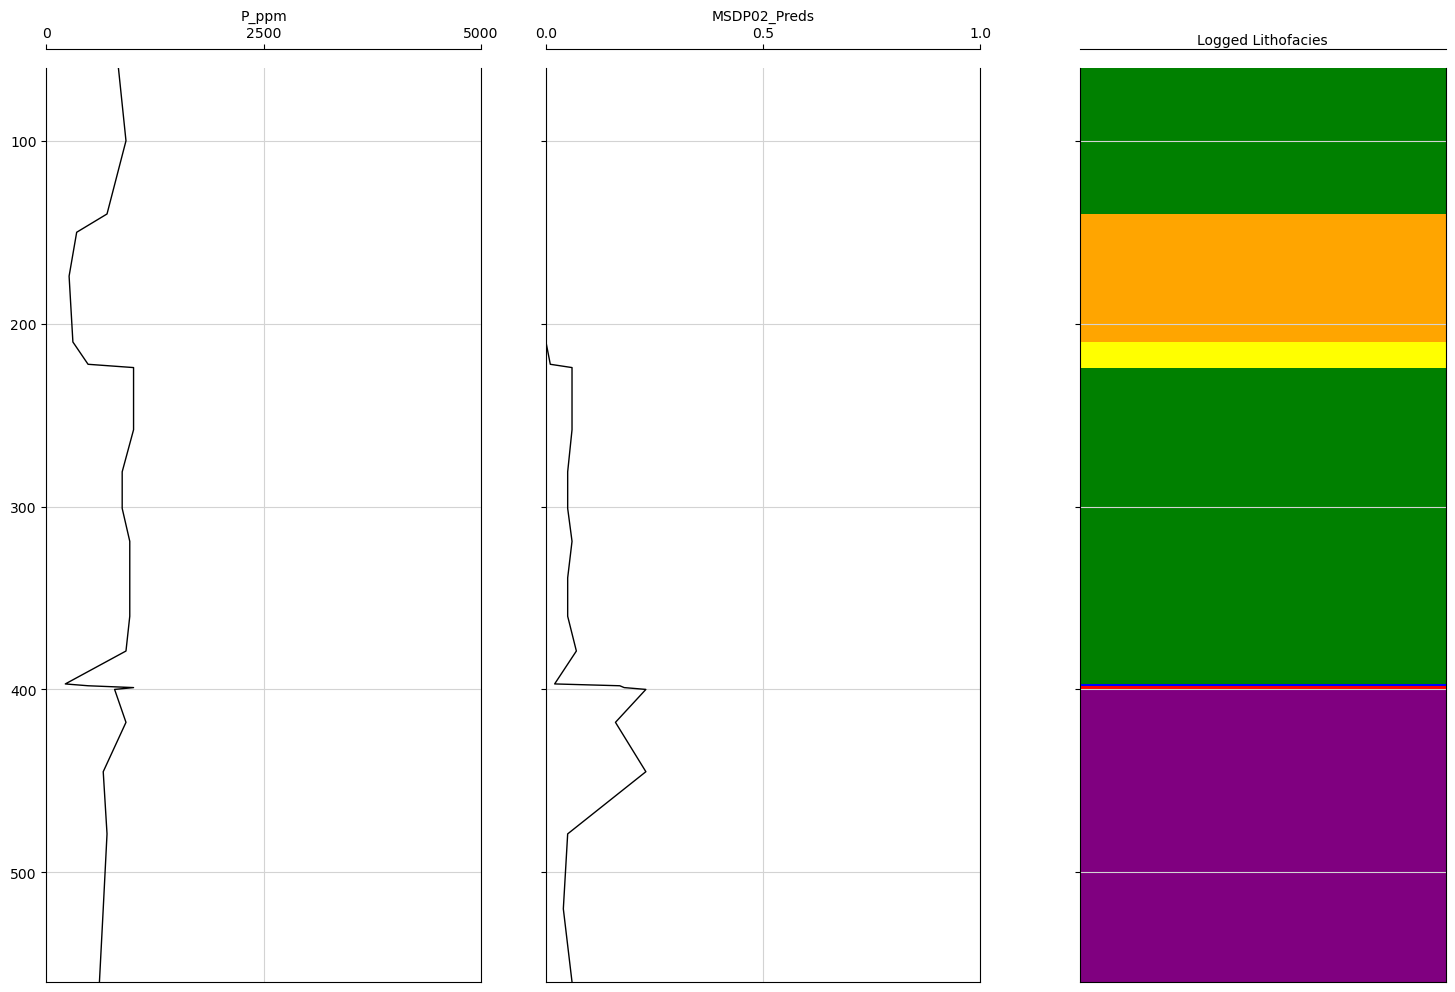

In [136]:
# Visualise Lithologies and Prdictions on Low Proability Hole

# Compare the results of clustering and cuttings interp
d1 = {'Siltstone': 1, 'Sandstone': 2, 'Conglomerate': 3, 'Dolomite Rock': 4, 'Autobreccia': 5, 'Basalt': 6}
colors1 = ['green', 'orange','yellow', 'blue', 'red', 'purple']
cmap1 = ListedColormap(colors1)

#Create function for strip log
def striplog_2(hole, bottom_depth, top_depth, var1, var2):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # MSDP01 Ti track
    ax1.plot(hole[var1], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax1.set_xlabel(var1)
    ax1.set_xlim(0, 5000)
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 2500, 5000])

    # MSDP01 P track
    ax2.plot(hole[var2], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax2.set_xlabel(var2)
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 0.5, 1])

    # Lithofacies
    ax3.pcolormesh([-1, 1], hole['DH_DEPTH_FROM'], hole['LITHOLOGY_NAME'][:-1].map(d1).to_numpy().reshape(-1, 1),
              cmap=cmap1, vmin=1, vmax=len(colors1))
    ax3.set_xticks([])
    ax3.set_aspect(0.01)
    ax3.set_xlabel("Logged Lithofacies")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible = False)
       
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

striplog_2(hole, 560, 60, "P_ppm", "MSDP02_Preds")

plt.savefig('outputs/MSDP02')
plt.show()

In [137]:
# Add average predicted basalt probabilities from model to a dataframe 
av_prob = []
for h in probs:
    av_prob.append(np.mean(h))

map['Basalt_prob'] = av_prob

map.to_csv('outputs/map.csv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Axes: xlabel='DH_NAME'>

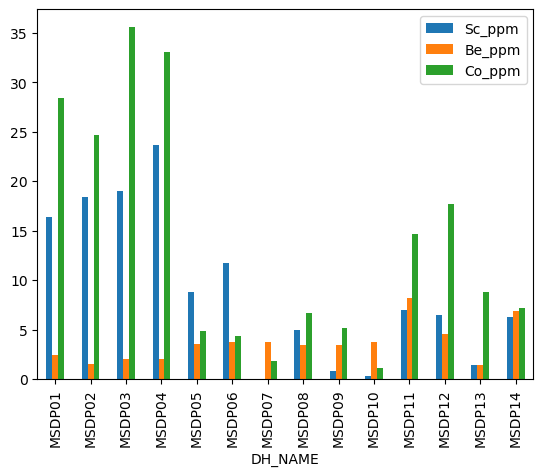

In [138]:
# Show differences in the most important feature across holes
df.groupby(["DH_NAME"])["Sc_ppm", "Be_ppm", "Co_ppm"].mean().plot.bar()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<Axes: xlabel='DH_NAME'>

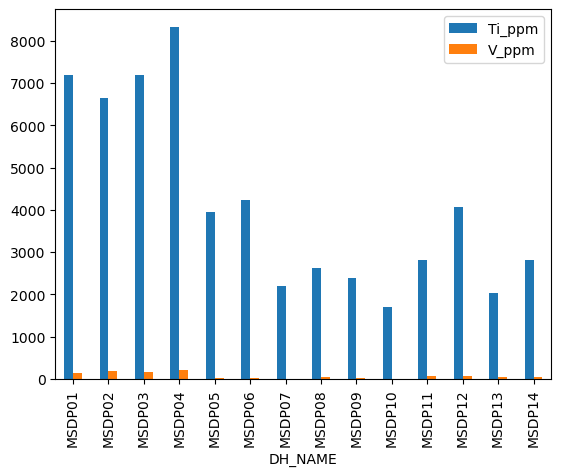

In [139]:
# Show differences in the most important feature across holes
df.groupby(["DH_NAME"])["Ti_ppm", "V_ppm"].mean().plot.bar()

In [140]:
# group by MSDP02
hole = df.loc[df['DH_NAME'] == 'MSDP12']
hole = hole.dropna(subset = ['LITHOLOGY_NAME'])
hole = hole.sort_values(by=['DH_DEPTH_FROM'])
hole['MSDP12_Preds'] = probs[11]


print(hole['LITHOLOGY_NAME'].unique())

['Amphibolite' 'Augen Gneiss' 'Quartz Rock (Metasomatic)' 'Orthogneiss'
 'Meta-Mafic Igneous Rock' 'Pegmatite (No Composition)' 'Metagranite'
 'Fault Breccia' 'Dacite']


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


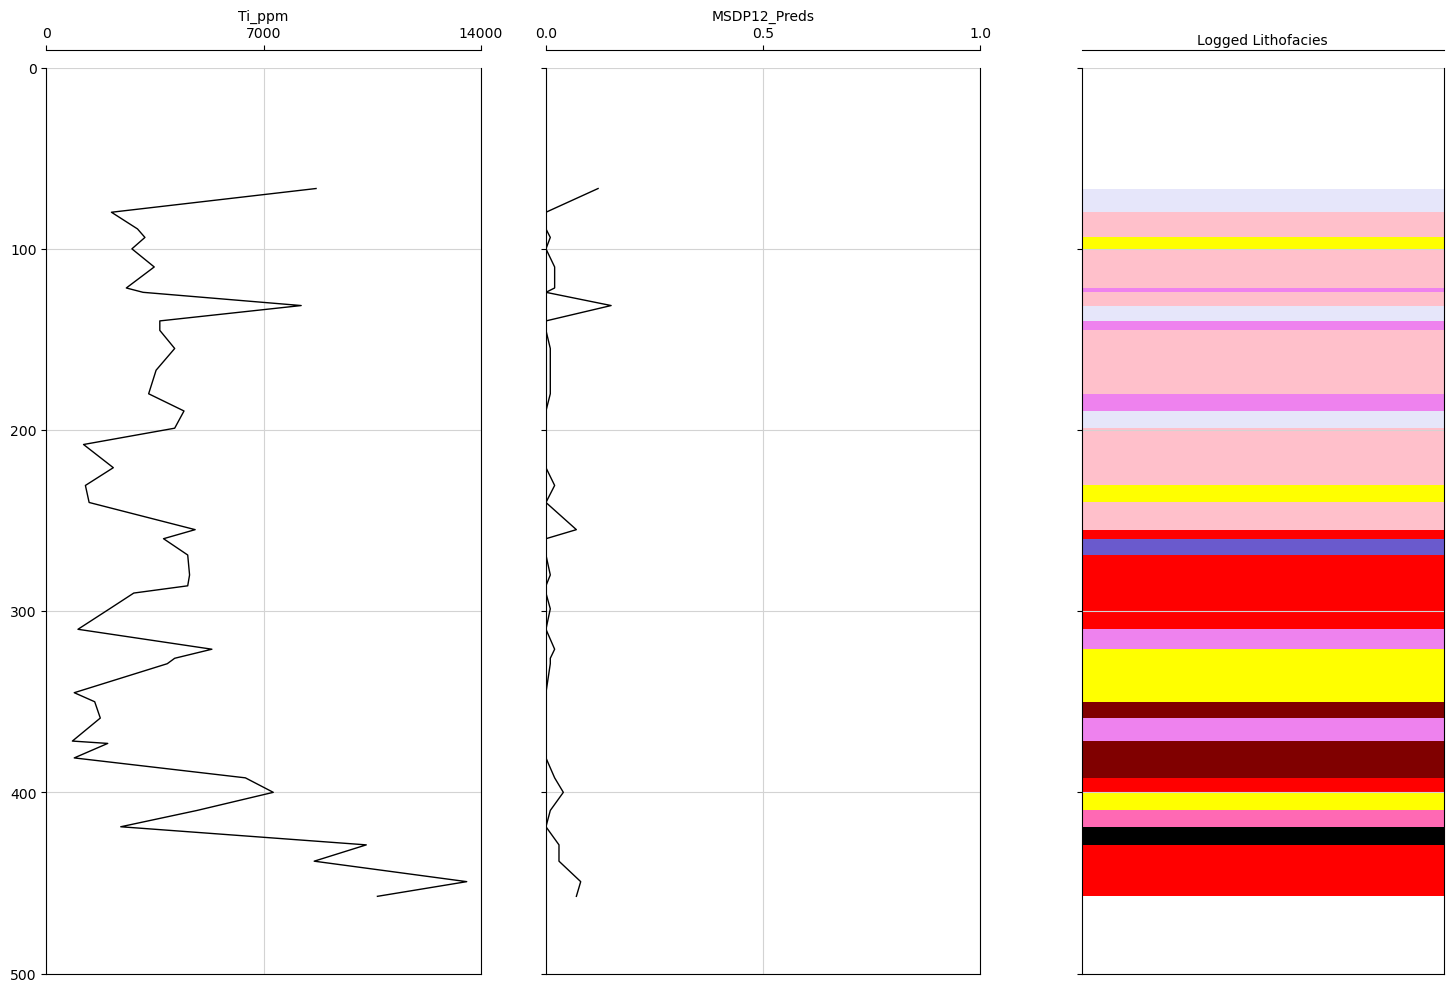

In [141]:
# Visualise Lithologies and Prdictions on Low Proability Hole

# Compare the results of clustering and cuttings interp
d1 = {'Amphibolite': 1, 'Augen Gneiss': 2, 'Quartz Rock (Metasomatic)': 3, 'Orthogneiss': 4, 'Meta-Mafic Igneous Rock': 5, 'Pegmatite (No Composition)': 6,
      'Metagranite': 7, 'Fault Breccia': 8, 'Dacite': 9}
colors1 = ['lavender', 'pink','yellow', 'violet', 'red', 'slateblue', 'maroon', 'hotpink', 'black', 'yellowgreen']
cmap1 = ListedColormap(colors1)

#Create function for strip log
def striplog_2(hole, bottom_depth, top_depth, var1, var2):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # MSDP01 Ti track
    ax1.plot(hole[var1], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax1.set_xlabel(var1)
    ax1.set_xlim(0, 14000)
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.set_xticks([0, 7000, 14000])

    # MSDP01 P track
    ax2.plot(hole[var2], hole['DH_DEPTH_FROM'], color = "black", linewidth = 1.0)
    ax2.set_xlabel(var2)
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 0.5, 1])

    # Lithofacies
    ax3.pcolormesh([-1, 1], hole['DH_DEPTH_FROM'], hole['LITHOLOGY_NAME'][:-1].map(d1).to_numpy().reshape(-1, 1),
              cmap=cmap1, vmin=1, vmax=len(colors1))
    ax3.set_xticks([])
    ax3.set_aspect(0.01)
    ax3.set_xlabel("Logged Lithofacies")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible = False)
       
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

striplog_2(hole, 500, 0, "Ti_ppm", "MSDP12_Preds")

plt.savefig('outputs/MSDP12')
plt.show()